<a href="https://colab.research.google.com/github/Carl0339887/temp/blob/master/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [30]:
#Get the stock quote 
df = web.DataReader('TSLA', data_source='yahoo', start='2012-01-01', end='2020-1-1') 
#Show the data 
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,5.900000,5.530000,5.788000,5.616000,4640500,5.616000
2012-01-04,5.734000,5.500000,5.642000,5.542000,3150500,5.542000
2012-01-05,5.586000,5.370000,5.552000,5.424000,5027500,5.424000
2012-01-06,5.558000,5.282000,5.440000,5.382000,4931500,5.382000
2012-01-09,5.498000,5.224000,5.400000,5.450000,4485000,5.450000
...,...,...,...,...,...,...
2019-12-24,85.094002,82.538002,83.671997,85.050003,40273500,85.050003
2019-12-26,86.695999,85.269997,85.582001,86.188004,53169500,86.188004
2019-12-27,87.061996,85.222000,87.000000,86.075996,49728500,86.075996


In [31]:
df.shape

(2012, 6)

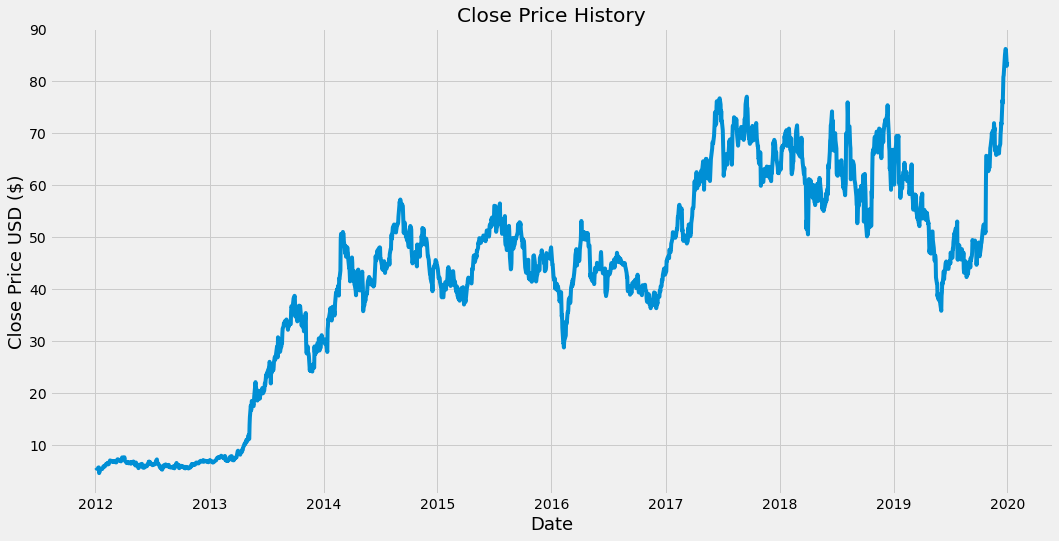

In [32]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [33]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

In [34]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [35]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [36]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [37]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1550/1550 [==============================] - 41s 27ms/step - loss: 0.0027


In [38]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    #Convert x_test to a numpy array 
x_test = np.array(x_test)
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

3.456705458702439

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


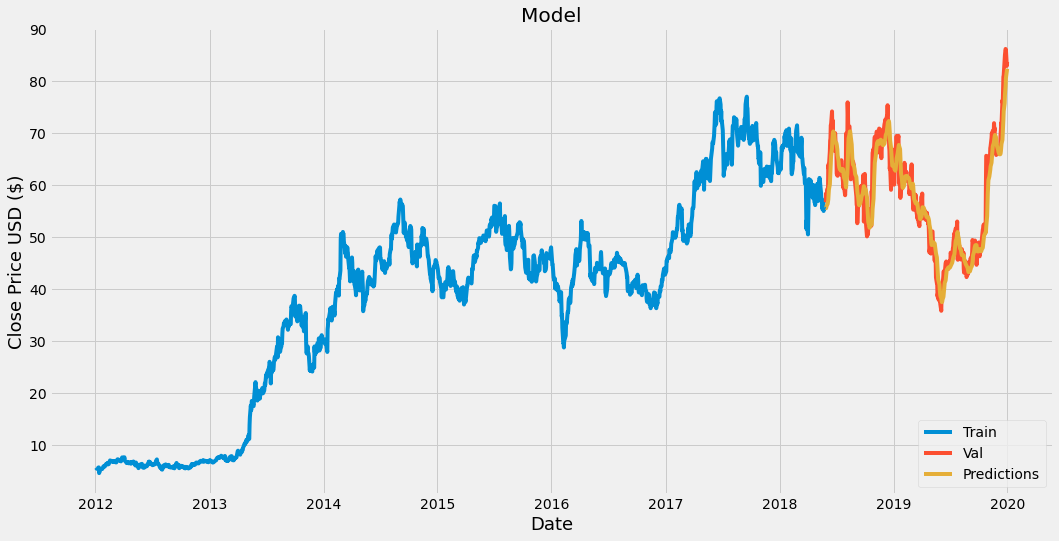

In [39]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


In [40]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2018-05-29,56.751999,55.564472
2018-05-30,58.344002,55.544529
2018-05-31,56.945999,55.814751
2018-06-01,58.363998,56.024967
2018-06-04,59.348000,56.364727
...,...,...
2019-12-24,85.050003,77.380775
2019-12-26,86.188004,79.003426
2019-12-27,86.075996,80.545479


In [41]:
#Get the quote
apple_quote2 = web.DataReader('TSLA', data_source='yahoo', start='2019-12-18', end='2019-12-18')
print(apple_quote2['Close'])

Date
2019-12-18    78.629997
Name: Close, dtype: float64
